In [1]:
from vis import barplot, recompute
import seaborn as sns 
import json 
import pathlib 
import pandas as pd 
import re 
import subprocess

ImportError: Matplotlib requires pyparsing>=2.2.1; you have 2.2.0

In [2]:
def compute_max_over_instructions(instruction_dirs, results_dir, idx=2, restrict=None): 
    df = pd.DataFrame(columns=["model", "instruction_dir", "results_dir", "type", "value"], dtype=object)
    for instruction_dir in instruction_dirs:
        oc_acc, poc_acc, sc_acc = recompute_all(instruction_dir, results_dir)
        models = set(oc_acc.keys()) & set(poc_acc.keys()) & set(sc_acc.keys())
        print(f"models {models}")
        if restrict is not None:
            models = [x for x in models if x in restrict]
        for model in models:
            df = df.append({"model": model, "instruction_dir": instruction_dir, "results_dir": results_dir, "type": "oc", "value": oc_acc[model][idx] }, ignore_index=True)
            df = df.append({"model": model, "instruction_dir": instruction_dir, "results_dir": results_dir, "type": "poc", "value": poc_acc[model][idx] }, ignore_index=True)
            df = df.append({"model": model, "instruction_dir": instruction_dir, "results_dir": results_dir, "type": "sc", "value": sc_acc[model][idx] }, ignore_index=True)
    max_df = pd.DataFrame(columns=["model", "instruction_dir", "results_dir", "type", "value"], dtype=object)
    done = []
    instruction_dirs = ["with_instructions", "short_instructions"]
    for i, row in df.iterrows():
        other_instruction_dir = [x for x in instruction_dirs if x != row['instruction_dir']][0]
        value1 = row['value']
        other_row = df[(df['model'] == row['model']) & (df['instruction_dir'] == other_instruction_dir) & 
                    (df['results_dir'] == row['results_dir']) & (df['type'] == row['type'])]
        try:
            value2 = other_row['value'].values[0]
        except IndexError:
            # print(f"row: {row}") 
            # print(f"other: {other_row}") 
            pass
        if value1 > value2:
            max_df = max_df.append(row, ignore_index=True)
        else:
            max_df = max_df.append(other_row, ignore_index=True)
    best_instruction_dir = "best_instructions"
    for i, row in max_df.iterrows():
        results_dir = row['results_dir']
        if row['type'] == "oc":
            exp_type = "object_control"
        elif row['type'] == "poc":
            exp_type = "passive_object_control"
        else:
            exp_type = "subject_control" 
        model = re.sub("-", "_", row['model'])
        model = re.sub("_qa", "", model)
        model = re.sub("_large", "", model)
        instruction_dir = row['instruction_dir']
        src_path = f"../{instruction_dir}/{results_dir}/{model}_{exp_type}.csv"
        out_path = f"../{best_instruction_dir}/{results_dir}/{model}_{exp_type}.csv"
        subprocess.Popen(["cp", src_path, out_path])
    return df, max_df

def recompute_all(instruction_dir, results_dir):
    pathlib.Path(f"../{instruction_dir}/{results_dir}_to_plot").mkdir(exist_ok=True)
    names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
    nicknames = json.load(open("../data/nicknames.json"))
    pre_oc_csvs = [
     f"../{instruction_dir}/{results_dir}/gpt_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_1.3b_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_2.7b_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_j_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/jurassic_object_control.csv",
     f"../{instruction_dir}/{results_dir}/jurassic_jumbo_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/t5_object_control.csv",
     f"../{instruction_dir}/{results_dir}/t0_object_control.csv"]

    print(f"recompute object control")
    oc_acc = recompute(pre_oc_csvs, names, nicknames, exp_name = "object-control", results_path=f"{instruction_dir}/{results_dir}_to_plot")   

    pre_poc_csvs = [
     f"../{instruction_dir}/{results_dir}/gpt_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_1.3b_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_2.7b_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_j_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/jurassic_passive_object_control.csv",
     f"../{instruction_dir}/{results_dir}/jurassic_jumbo_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/t5_passive_object_control.csv",
     f"../{instruction_dir}/{results_dir}/t0_passive_object_control.csv"]
    
    print(f"recompute passive object control")
    poc_acc = recompute(pre_poc_csvs, names, nicknames, exp_name = "object-control-passive", results_path=f"{instruction_dir}/{results_dir}_to_plot")   

    pre_sc_csvs =  [
     f"../{instruction_dir}/{results_dir}/gpt_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_1.3b_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_2.7b_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_j_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/jurassic_subject_control.csv",
     f"../{instruction_dir}/{results_dir}/jurassic_jumbo_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/t5_subject_control.csv",
     f"../{instruction_dir}/{results_dir}/t0_subject_control.csv"]

    print(f"recompute subject control")
    sc_acc = recompute(pre_sc_csvs, names, nicknames, exp_name = "subject-control", results_path=f"{instruction_dir}/{results_dir}_to_plot") 
    return oc_acc, poc_acc, sc_acc

def plot_all(instruction_dir, results_dir, recompute=True, filtered=True, ignore_first_only = False):
    if recompute:
        print(f"recomputing...")
        recompute_all(instruction_dir, results_dir)

    oc_csvs=[
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_1.3b_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_2.7b_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_j_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_jumbo_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/t5_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/t0_object_control.csv"]

    sc_csvs=[
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_1.3b_subject_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_2.7b_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_j_subject_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_jumbo_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/t5_subject_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/t0_subject_control.csv"]

    poc_csvs=[
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_passive_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_1.3b_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_2.7b_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_j_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_passive_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_jumbo_passive_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/t5_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/t0_passive_object_control.csv"]

    csv_data = {"Object control": oc_csvs, "Passive object control": poc_csvs, "Subject control": sc_csvs}
    print("plotting...")
    g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=filtered, ignore_first_only=ignore_first_only)
    g.figure.set_size_inches(9.5, 4.5)

    sns.despine()

In [3]:
df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results")

NameError: name 'pd' is not defined

In [91]:
df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_hacked")

recompute object control
FileNotFound: ../with_instructions/results_hacked/t5_object_control.csv
recompute passive object control
FileNotFound: ../with_instructions/results_hacked/t5_passive_object_control.csv
recompute subject control
FileNotFound: ../with_instructions/results_hacked/t5_subject_control.csv
models {'gpt-neo-2.7b', 't0', 'gpt-j', 'jurassic-jumbo', 'gpt', 'jurassic-large', 'gpt-neo-1.3b'}
recompute object control
FileNotFound: ../short_instructions/results_hacked/t5_object_control.csv
recompute passive object control
FileNotFound: ../short_instructions/results_hacked/t5_passive_object_control.csv
recompute subject control
FileNotFound: ../short_instructions/results_hacked/t5_subject_control.csv
models {'gpt-neo-2.7b', 't0', 'gpt-j', 'jurassic-jumbo', 'gpt', 'jurassic-large', 'gpt-neo-1.3b'}


recomputing...
recompute object control
recompute passive object control
recompute subject control
plotting...
recomputing...
recompute object control
recompute passive object control
recompute subject control
plotting...
recomputing...
recompute object control
recompute passive object control
recompute subject control
plotting...


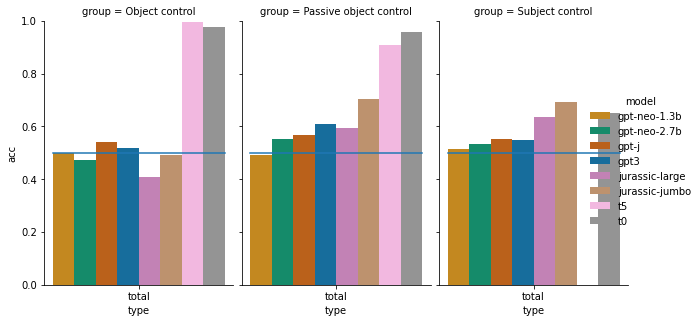

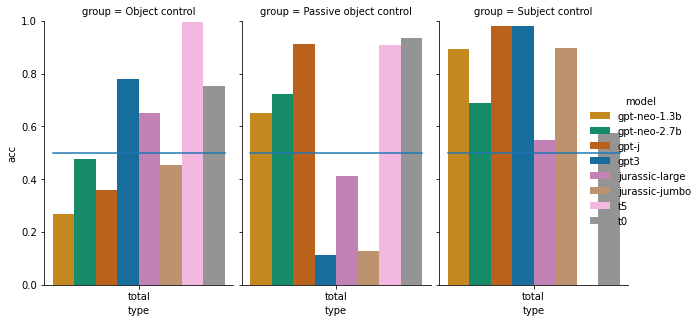

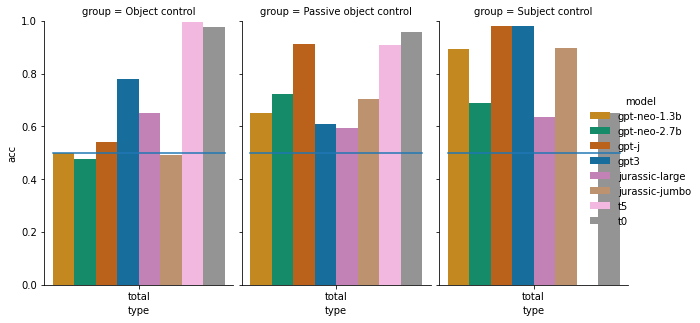

In [92]:
plot_all("with_instructions", "results", recompute=True)
plot_all("short_instructions", "results", recompute=True)
plot_all("best_instructions", "results", recompute=True)

recomputing...
recompute object control
FileNotFound: ../with_instructions/results_hacked/t5_object_control.csv
recompute passive object control
FileNotFound: ../with_instructions/results_hacked/t5_passive_object_control.csv
recompute subject control
FileNotFound: ../with_instructions/results_hacked/t5_subject_control.csv
plotting...
Not found: ../with_instructions/results_hacked_to_plot/t5_object_control.csv
Not found: ../with_instructions/results_hacked_to_plot/t5_passive_object_control.csv
Not found: ../with_instructions/results_hacked_to_plot/t5_subject_control.csv
recomputing...
recompute object control
FileNotFound: ../short_instructions/results_hacked/t5_object_control.csv
recompute passive object control
FileNotFound: ../short_instructions/results_hacked/t5_passive_object_control.csv
recompute subject control
FileNotFound: ../short_instructions/results_hacked/t5_subject_control.csv
plotting...
Not found: ../short_instructions/results_hacked_to_plot/t5_object_control.csv
Not fou

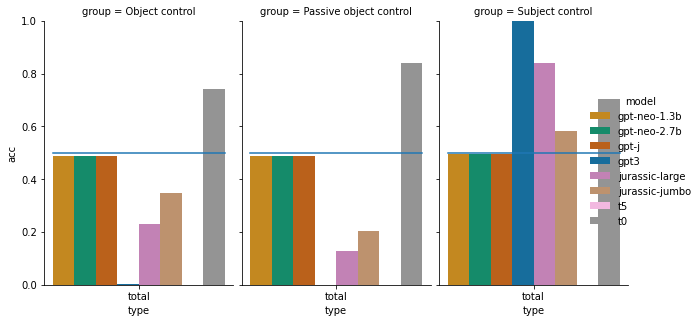

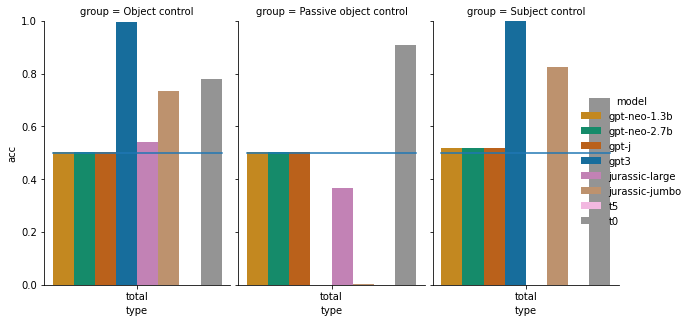

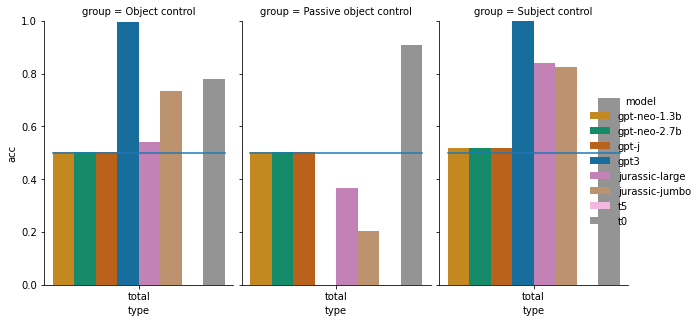

In [93]:
plot_all("with_instructions", "results_hacked", recompute=True)
plot_all("short_instructions", "results_hacked", recompute=True)
plot_all("best_instructions", "results_hacked", recompute=True)

In [ ]:
plot_all("with_instructions", "results_just_prompt_agent", recompute=True)
plot_all("short_instructions", "results_just_prompt_agent", recompute=True)

In [ ]:
plot_all("with_instructions", "results_just_prompt_patient", recompute=True)
plot_all("short_instructions", "results_just_prompt_patient", recompute=True)